In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.stats import kendalltau

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.style.use('seaborn')

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 16,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

matplotlib.rcParams.update(nice_fonts)

In [3]:
flist = sorted(glob.glob('./tau_*'))

In [4]:
tau_sink = []
for f in flist:
    tau_sink.append(np.genfromtxt(f))

In [5]:
demos = np.arange(10,1920,50,dtype='int')

In [6]:
# Baseline (no generalisation)
from itertools import permutations 
obj_id_list = []
for r in range(2,7):
    obj_id_list = obj_id_list + list(permutations(range(0, 6),r=r))
    
perms = np.ones((len(obj_id_list),6))*100
seq_len = []
for j,obj_idx in enumerate(obj_id_list):
    seq_len.append(len(obj_idx))
    perms[j,0:len(obj_idx)] = obj_idx
    

In [7]:
baseline_tau = []
baseline_pre = []
for d in demos:
    perms_copy = np.copy(perms)
    perms_shuffled = np.copy(perms_copy[d:,:])
    np.random.shuffle(perms_shuffled)
    perms_copy[d:,:] = perms_shuffled
    tau_list = []
    acc_list = []
    pre_list = []
    for k in range(perms.shape[0]):
        tau,p = kendalltau(perms[k,:seq_len[k]],perms_copy[k,:seq_len[k]])
        tau_list.append(tau)
        acc = np.array_equal(perms[k,:seq_len[k]],perms_copy[k,:seq_len[k]])
        acc_list.append(acc)
        pre_list.append(np.sum(perms[k,:seq_len[k]]==perms_copy[k,:seq_len[k]])/seq_len[k])
    baseline_tau.append(tau_list)
    baseline_pre.append(pre_list)
    
hists_baseline = []
for t in np.vstack(baseline_tau):
    h,_ = np.histogram(t,np.linspace(-1,1,10))
    hists_baseline.append(h)

In [8]:
tmean = np.array([np.nanmean(t) for t in tau_sink])
tstd = np.array([np.nanstd(t) for t in tau_sink])

In [9]:
bmean = np.array([np.mean(t) for t in baseline_tau])
bstd = np.array([np.std(t) for t in baseline_tau])

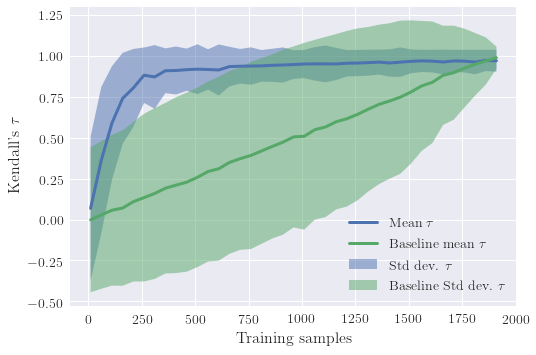

In [10]:
plt.plot(demos[0:len(tmean)],tmean,linewidth=3,label='Mean $\\tau$')
plt.fill_between(demos[0:len(tmean)],tmean-tstd,tmean+tstd,alpha=0.5,label='Std dev. $\\tau$')
plt.plot(demos[0:len(bmean)],bmean,linewidth=3,label='Baseline mean $\\tau$')
plt.fill_between(demos[0:len(bmean)],bmean-bstd,bmean+bstd,alpha=0.5,label='Baseline Std dev. $\\tau$')

plt.xlabel('Training samples')
plt.ylabel('Kendall\'s $\\tau$')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
hists = []
for t in tau_sink:
    h, _ = np.histogram(t,np.linspace(-1,1,10))
    hists.append(h)

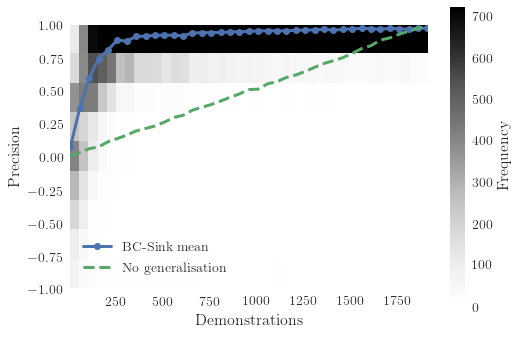

In [19]:
# Compare on distribution over sinkhorn
plt.imshow(np.vstack(hists).T,extent=(demos[0],demos[-1],-1,1),aspect=700,origin='lower',vmin=0,vmax=720,interpolation='None')
plt.plot(demos[0:len(tmean)],tmean,'-o',linewidth=3,label='BC-Sink mean')
plt.plot(demos,bmean,'--',linewidth=3,label='No generalisation')
plt.colorbar(label='Frequency')
plt.legend(loc='lower left')
plt.grid()
plt.ylabel('Precision')
plt.xlabel('Demonstrations')
plt.savefig('Generalisation_subsets.pdf')
plt.show()

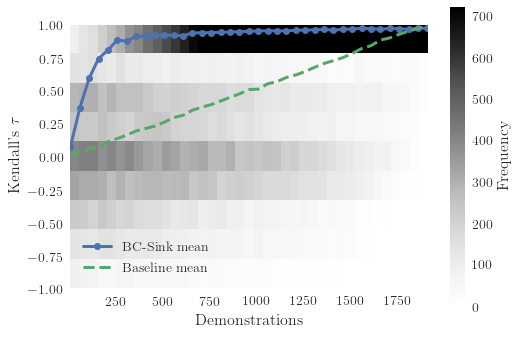

In [13]:
# Compare on distribution over baseline
plt.imshow(np.vstack(hists_baseline).T,extent=(demos[0],demos[-1],-1,1),aspect=700,origin='lower',vmin=0,vmax=720,interpolation='None')
plt.plot(demos[0:len(tmean)],tmean,'-o',linewidth=3,label='BC-Sink mean')
plt.plot(demos[0:len(bmean)],bmean,'--',linewidth=3,label='Baseline mean')
plt.colorbar(label='Frequency')
plt.legend(loc='lower left')
plt.grid()
plt.ylabel('Kendall\'s $\\tau$')
plt.xlabel('Demonstrations')
plt.show()

In [14]:
flist = sorted(glob.glob('./Precision_*'))
pre_sink = []
for f in flist:
    pre_sink.append(np.genfromtxt(f))

In [15]:
hists_p = []
for t in pre_sink:
    h,_ = np.histogram(t,np.linspace(0,1,10))
    hists_p.append(h)

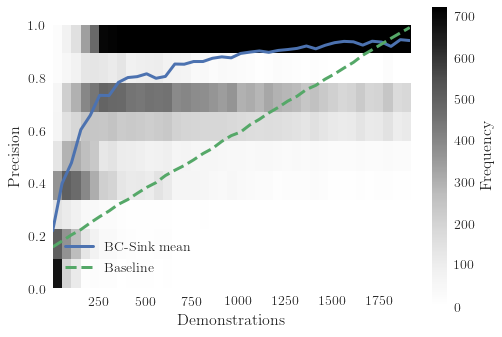

In [24]:
# Compare on precision distribution (nb precision is never perfect as there are multiple possible ways to build tower, better to compare order)
plt.imshow(np.vstack(hists_p).T,extent=(demos[0],demos[-1],0,1),aspect=1400,origin='lower',vmin=0,vmax=720,interpolation='None')
plt.plot(demos[0:len(pre_sink)],[np.mean(pre) for pre in pre_sink],linewidth=3,label='BC-Sink mean')
plt.plot(demos,[np.mean(pre) for pre in baseline_pre],'--',linewidth=3,label='Baseline')
plt.colorbar(label='Frequency')
plt.legend(loc='lower left')
plt.grid()
plt.ylabel('Precision')
plt.xlabel('Demonstrations')
plt.show()